# Visual Deep Learning: Plant Health Model
### Gabriel Beutl & Alexander Schwab

This notebook describes the creation of a model to evaluate the health of plants. The model was trained with leaves from an apple tree. With this, an application should be able to identify if a tree is unhealthy, by providing a image form a leave of the tree. 

The idea to create this model is based on a project that was started last semester. The project GreenThumb is a plant health tracking app, that allows the user to keep track of the health of a plant. With the addition of a trained ai model, the application could be improved a lot in its functionality.

Three models will be implemented and compared with each other.

###  Applied steps for creating this Machine Learning Modes:

01. Setup
02. Load image data and apply data augmentation
03. Define model
04. Display model structure
05. Training model
06. Write history and plot graphs
07. Evaluate Model
08. Predict with model and display ROC
09. Save trained model
10. Load trained model
11. Test trained model

### Experiments:
The notebook tries different experiments for the creation of the best model. As such, steps 3 - 8 are repeated three times with different models.

The results will be discussed shortly at the end of the notebook.

### 1. Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import metrics
from sklearn import metrics as skmetrics

from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Environment Variables
EPOCHS = 25
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
LEARNING_RATE = 0.001
MODEL_NAME = 'plant_health_model.h5'

#Folder for the data
train_data_dir = './plant_images/train'
valid_data_dir = './plant_images/valid'
test_data_dir = './plant_images/test'

#Different Metrics that get printed in the history
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.AUC(name='auc'),
      metrics.MeanAbsoluteError(name='mae'),
      metrics.MeanSquaredError(name='mse')
]

### 2. Load Image Data and apply data augmentation and preprocessing

#### The structure of the folder is the following:

```
plant_images
└───train
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
└───valid
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
└───test
│   └───Apple_healthy
│   │        image1.png
│   │        ...
│   └───Apple_unhealthy
│            image1.png
│            ...
```

The train folder includes around 1400 images for the training.

The valid folder includes around 700 images to validate the trained model.

The test folder includes again around 120 images to test the model.

#### Augmentation:
For the augmentation a ImageDataGenerator is used. With this the images for the training and validation are rescaled, sheared, rotated, flipped and zoomed.

The test images are only rescaled.

In [3]:
#Create augmented training data
train_datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split=0.2,
                                   cval=0)

#Create augmented training data
train_dataset = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training')

#Create augmented validation data
validation_dataset = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='validation')

test_datagen = ImageDataGenerator(rescale=(1. / 255))

#Create test data
test_dataset = test_datagen.flow_from_directory(test_data_dir,
                                                      target_size=IMG_SIZE,
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode='categorical')

Found 1458 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


In [4]:
# Checks if classes where found and displays them
num_classes = train_dataset.num_classes
class_names = list(train_dataset.class_indices.keys())
print(class_names)

['Apple__healthy', 'Apple__unhealthy']


### Display augmented image data

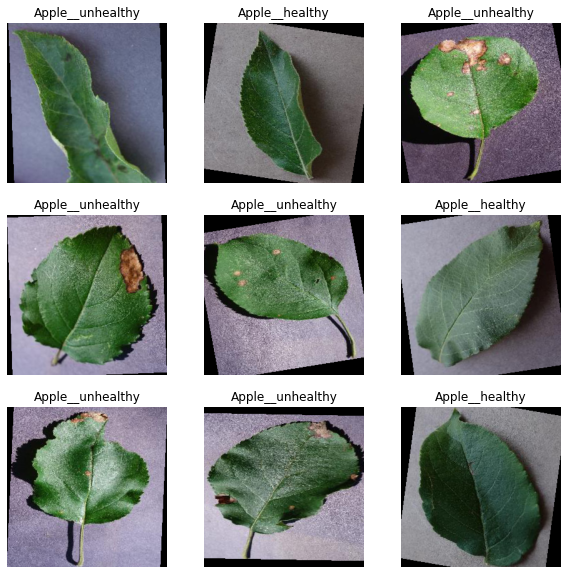

In [5]:
# display the random validation data for testing
x,y = validation_dataset.next()
labels = list(np.argmax(l) for l in y)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x[i])
  plt.title(class_names[labels[i]])
  plt.axis("off")

## The experiments with different models start here

### 3. Create and compile model 1

This model uses two hidden convolution layers and one dense layer to analyse the images. In between the hidden layers, max-pooling manipulates the values, to create a better learning base. Based on literature the best hidden layer activation is the relu function and for the dense activation softmax. For the loss function, the categorical_crossentropy or the binary-crossentropy (since there are only two classes) was possible for image recognition. For this example, categoriacal crossentropy worked better. Finally, this model also normalizes the output of the hidden input layer. Thus, reducing covariate shift.

In [6]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 1

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 128)     3456      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147456    
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

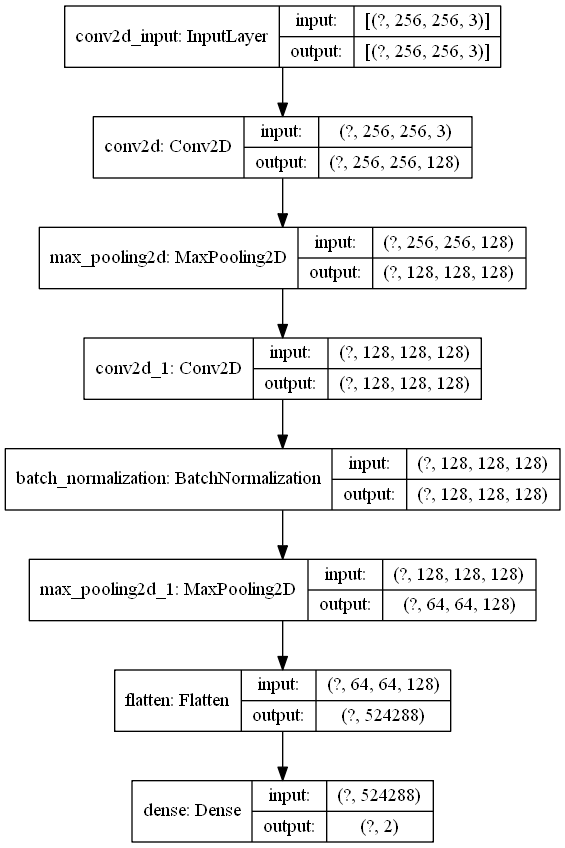

In [9]:
tf.keras.utils.plot_model(model1, show_shapes=True)

### 5. Training model 1

In [10]:
def train_model(model, model_name):
    filepath = './models/' + model_name + '.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        validation_data=validation_dataset,
                        callbacks=callbacks_list)
    return history

history1 = train_model(model1, "Model_1")

Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 2.6319 - tp: 1152.0000 - fp: 306.0000 - tn: 1152.0000 - fn: 306.0000 - accuracy: 0.7901 - precision: 0.7901 - auc: 0.8367 - mae: 0.2089 - mse: 0.1891
Epoch 00001: val_accuracy improved from -inf to 0.80159, saving model to ./models\Model_1.hdf5
46/46 [==============================] - 16s 357ms/step - loss: 2.6319 - tp: 1152.0000 - fp: 306.0000 - tn: 1152.0000 - fn: 306.0000 - accuracy: 0.7901 - precision: 0.7901 - auc: 0.8367 - mae: 0.2089 - mse: 0.1891 - val_loss: 0.3799 - val_tp: 101.0000 - val_fp: 25.0000 - val_tn: 101.0000 - val_fn: 25.0000 - val_accuracy: 0.8016 - val_precision: 0.8016 - val_auc: 0.9191 - val_mae: 0.2761 - val_mse: 0.1197
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.6925 - tp: 1268.0000 - fp: 190.0000 - tn: 1268.0000 - fn: 190.0000 - accuracy: 0.8697 - precision: 0.8697 - auc: 0.9241 - mae: 0.1335 - mse: 0.1084
Epoch 00002: val_accuracy did not improve from 0.80159
46/46 

Epoch 13/25
46/46 [==============================] - ETA: 0s - loss: 0.2797 - tp: 1312.0000 - fp: 146.0000 - tn: 1312.0000 - fn: 146.0000 - accuracy: 0.8999 - precision: 0.8999 - auc: 0.9629 - mae: 0.1154 - mse: 0.0737
Epoch 00013: val_accuracy did not improve from 0.94444
46/46 [==============================] - 16s 348ms/step - loss: 0.2797 - tp: 1312.0000 - fp: 146.0000 - tn: 1312.0000 - fn: 146.0000 - accuracy: 0.8999 - precision: 0.8999 - auc: 0.9629 - mae: 0.1154 - mse: 0.0737 - val_loss: 0.3343 - val_tp: 104.0000 - val_fp: 22.0000 - val_tn: 104.0000 - val_fn: 22.0000 - val_accuracy: 0.8254 - val_precision: 0.8254 - val_auc: 0.9297 - val_mae: 0.2116 - val_mse: 0.1092
Epoch 14/25
46/46 [==============================] - ETA: 0s - loss: 0.3291 - tp: 1283.0000 - fp: 175.0000 - tn: 1283.0000 - fn: 175.0000 - accuracy: 0.8800 - precision: 0.8800 - auc: 0.9509 - mae: 0.1395 - mse: 0.0901
Epoch 00014: val_accuracy did not improve from 0.94444
46/46 [==============================] - 16s

46/46 [==============================] - ETA: 0s - loss: 0.2386 - tp: 1325.0000 - fp: 133.0000 - tn: 1325.0000 - fn: 133.0000 - accuracy: 0.9088 - precision: 0.9088 - auc: 0.9684 - mae: 0.1147 - mse: 0.0674
Epoch 00025: val_accuracy did not improve from 0.94444
46/46 [==============================] - 15s 337ms/step - loss: 0.2386 - tp: 1325.0000 - fp: 133.0000 - tn: 1325.0000 - fn: 133.0000 - accuracy: 0.9088 - precision: 0.9088 - auc: 0.9684 - mae: 0.1147 - mse: 0.0674 - val_loss: 0.1953 - val_tp: 117.0000 - val_fp: 9.0000 - val_tn: 117.0000 - val_fn: 9.0000 - val_accuracy: 0.9286 - val_precision: 0.9286 - val_auc: 0.9746 - val_mae: 0.0930 - val_mse: 0.0571


### 6. Write history and plot graphs 1

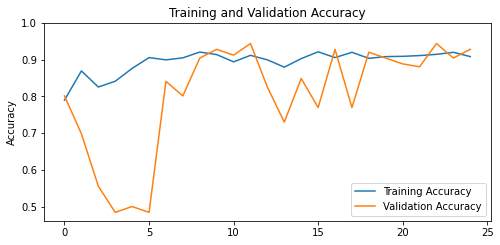

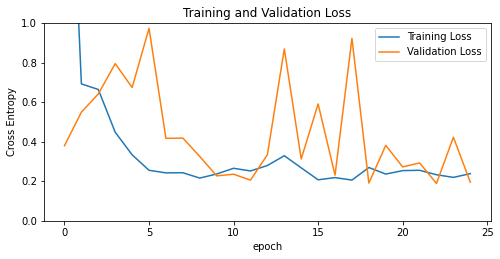

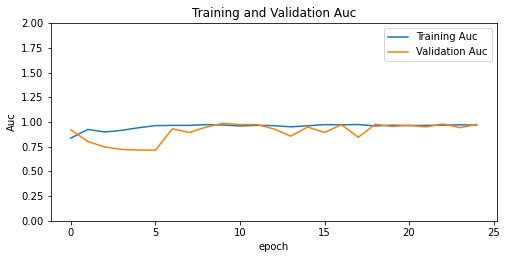

In [11]:
def print_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    auc = history.history['auc']
    val_auc = history.history['val_auc']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(auc, label='Training Auc')
    plt.plot(val_auc, label='Validation Auc')
    plt.legend(loc='upper right')
    plt.ylabel('Auc')
    plt.ylim([0,2.0])
    plt.title('Training and Validation Auc')
    plt.xlabel('epoch')
    plt.show()

print_history(history1)

### 7. Evaluate the model 1

In [12]:
def print_model_evaluation(model):
    result = model.evaluate(test_dataset)
    metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "auc", "mae", "mse"]
    for i in range(len(result)):
        print("{} : {}".format(metrics[i],round(result[i], 3)))

print_model_evaluation(model1);

714/714 [==============================] - 3s 4ms/step - loss: 0.4899 - tp: 607.0000 - fp: 107.0000 - tn: 607.0000 - fn: 107.0000 - accuracy: 0.8501 - precision: 0.8501 - auc: 0.9362 - mae: 0.1512 - mse: 0.1226
loss : 0.49
tp : 607.0
fp : 107.0
tn : 607.0
fn : 107.0
accuracy : 0.85
precision : 0.85
auc : 0.936
mae : 0.151
mse : 0.123


### 8. Predict with model 1

Label Predictions:
 [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Real Labels:
 [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]

Con

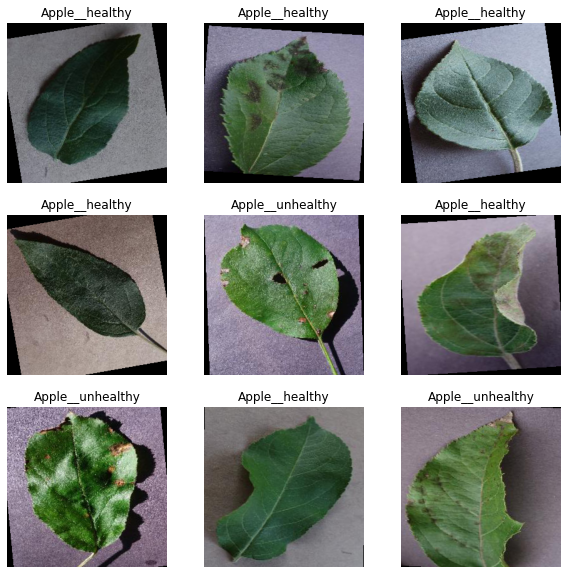

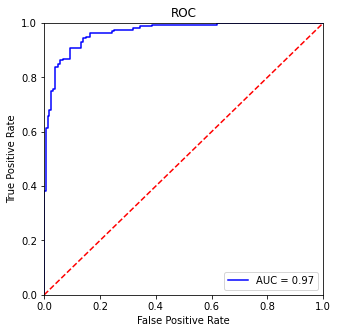

In [13]:
#prediction does not predict all images but only a part amount
def predict_and_print_roc(model):
    #Retrieve one batch of images from the test set
    train_dataset.reset()

    image_batch = []
    label_batch = []
    max_iter = 5 # maximum number of iterations, in each iteration one batch is generated;
    i = 0
    for d, l in train_dataset:
        image_batch.append(d)
        label_batch.append(l)
        i += 1
        if i == max_iter:
           break

    image_batch = np.array(image_batch)
    image_batch = np.reshape(image_batch, (image_batch.shape[0] * image_batch.shape[1], ) + image_batch.shape[2: ])

    label_batch = np.array(label_batch)
    label_batch = np.reshape(label_batch, (label_batch.shape[0] * label_batch.shape[1], ) + label_batch.shape[2: ])


    # Predict the images from the batch
    predictions = model.predict(image_batch)

    # Visualise the actual value and the prediction in numerical form
    probs = list(np.argmax(x) for x in predictions)
    labels = list(np.argmax(x) for x in label_batch)
    print('Label Predictions:\n', probs)
    print('Real Labels:\n', labels)

    confusion = confusion_matrix(labels, probs)
    print('\nConfusion Matrix:')
    print(confusion)

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, probs)))

    #Print the first 9 Images from the batch and the estimated prediction.
    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i])
      plt.title(class_names[probs[i]])
      plt.axis("off")

    #Calculate the roc curve
    fpr, tpr, _ = skmetrics.roc_curve(label_batch.ravel(), predictions.ravel())
    roc_auc = skmetrics.auc(fpr, tpr)

    #Display ROC curve and the AUC
    plt.figure(figsize=(5, 5))
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

predict_and_print_roc(model1);

### 3. Create and compile model 2

This model uses compared to the previous model three convolution layers and two dense layers. The value of the neurons are decreased at each layer.

In [14]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu', use_bias=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 128)     3456      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      36864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

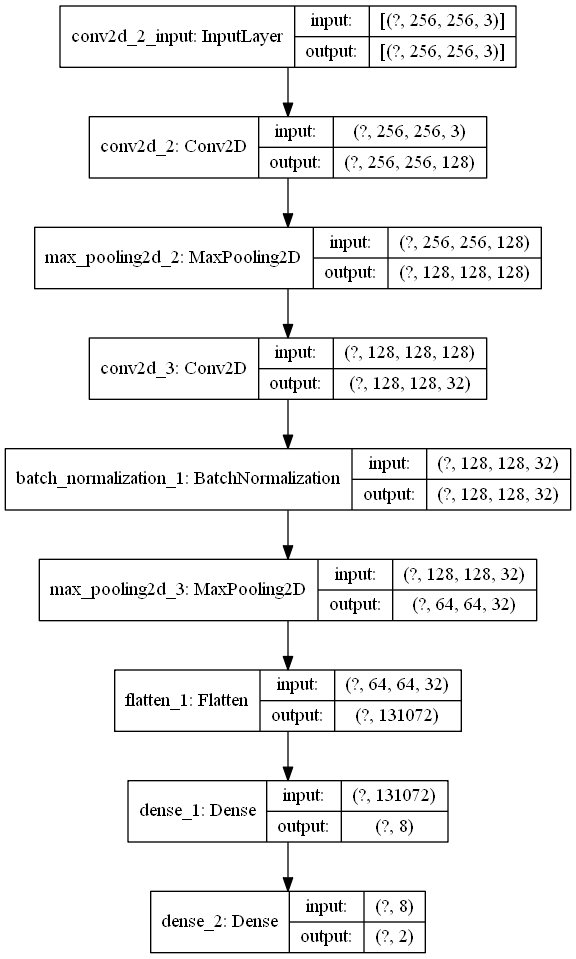

In [16]:
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)

### 5. Training model 2

In [17]:
history2 = train_model(model2, "Model_2")

Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 0.8180 - tp: 1580.0000 - fp: 592.0000 - tn: 1580.0000 - fn: 592.0000 - accuracy: 0.7274 - precision: 0.7274 - auc: 0.7974 - mae: 0.3428 - mse: 0.1960
Epoch 00001: val_accuracy improved from -inf to 0.48413, saving model to ./models\Model_2.hdf5
46/46 [==============================] - 16s 354ms/step - loss: 0.8180 - tp: 1580.0000 - fp: 592.0000 - tn: 1580.0000 - fn: 592.0000 - accuracy: 0.7274 - precision: 0.7274 - auc: 0.7974 - mae: 0.3428 - mse: 0.1960 - val_loss: 11.5489 - val_tp: 61.0000 - val_fp: 65.0000 - val_tn: 61.0000 - val_fn: 65.0000 - val_accuracy: 0.4841 - val_precision: 0.4841 - val_auc: 0.4841 - val_mae: 0.5159 - val_mse: 0.5159
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.5592 - tp: 1234.0000 - fp: 224.0000 - tn: 1234.0000 - fn: 224.0000 - accuracy: 0.8464 - precision: 0.8464 - auc: 0.8797 - mae: 0.3452 - mse: 0.1751
Epoch 00002: val_accuracy improved from 0.48413 to 0.88889, sa

Epoch 13/25
46/46 [==============================] - ETA: 0s - loss: 0.3111 - tp: 1338.0000 - fp: 120.0000 - tn: 1338.0000 - fn: 120.0000 - accuracy: 0.9177 - precision: 0.9177 - auc: 0.9517 - mae: 0.2199 - mse: 0.0882
Epoch 00013: val_accuracy did not improve from 0.94444
46/46 [==============================] - 15s 335ms/step - loss: 0.3111 - tp: 1338.0000 - fp: 120.0000 - tn: 1338.0000 - fn: 120.0000 - accuracy: 0.9177 - precision: 0.9177 - auc: 0.9517 - mae: 0.2199 - mse: 0.0882 - val_loss: 0.4113 - val_tp: 107.0000 - val_fp: 19.0000 - val_tn: 107.0000 - val_fn: 19.0000 - val_accuracy: 0.8492 - val_precision: 0.8492 - val_auc: 0.8931 - val_mae: 0.2981 - val_mse: 0.1286
Epoch 14/25
46/46 [==============================] - ETA: 0s - loss: 0.2926 - tp: 1335.0000 - fp: 123.0000 - tn: 1335.0000 - fn: 123.0000 - accuracy: 0.9156 - precision: 0.9156 - auc: 0.9598 - mae: 0.2108 - mse: 0.0833
Epoch 00014: val_accuracy did not improve from 0.94444
46/46 [==============================] - 15s

Epoch 25/25
46/46 [==============================] - ETA: 0s - loss: 0.2216 - tp: 1364.0000 - fp: 94.0000 - tn: 1364.0000 - fn: 94.0000 - accuracy: 0.9355 - precision: 0.9355 - auc: 0.9732 - mae: 0.1598 - mse: 0.0584
Epoch 00025: val_accuracy did not improve from 0.97619
46/46 [==============================] - 16s 352ms/step - loss: 0.2216 - tp: 1364.0000 - fp: 94.0000 - tn: 1364.0000 - fn: 94.0000 - accuracy: 0.9355 - precision: 0.9355 - auc: 0.9732 - mae: 0.1598 - mse: 0.0584 - val_loss: 0.7747 - val_tp: 98.0000 - val_fp: 28.0000 - val_tn: 98.0000 - val_fn: 28.0000 - val_accuracy: 0.7778 - val_precision: 0.7778 - val_auc: 0.8361 - val_mae: 0.2513 - val_mse: 0.1886


### 6. Display History 2

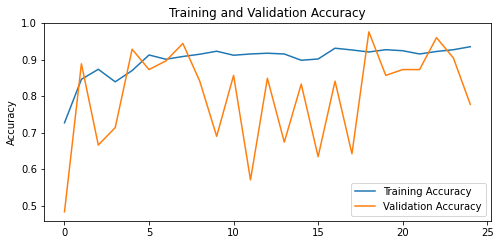

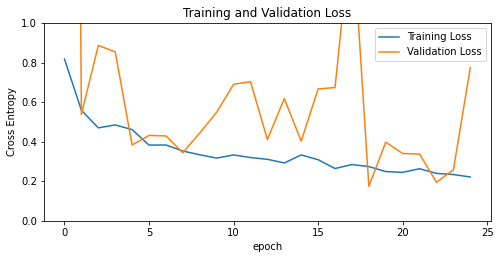

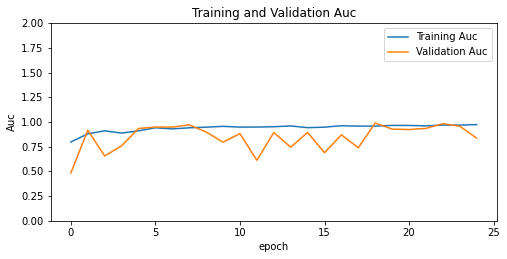

In [18]:
print_history(history2)

### 7. Evaluate the model 2

In [19]:
print_model_evaluation(model2);

714/714 [==============================] - 3s 5ms/step - loss: 1.6439 - tp: 505.0000 - fp: 209.0000 - tn: 505.0000 - fn: 209.0000 - accuracy: 0.7073 - precision: 0.7073 - auc: 0.7633 - mae: 0.2996 - mse: 0.2625
loss : 1.644
tp : 505.0
fp : 209.0
tn : 505.0
fn : 209.0
accuracy : 0.707
precision : 0.707
auc : 0.763
mae : 0.3
mse : 0.262


### 8. Predict with model 2

Label Predictions:
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Real Labels:
 [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

Con

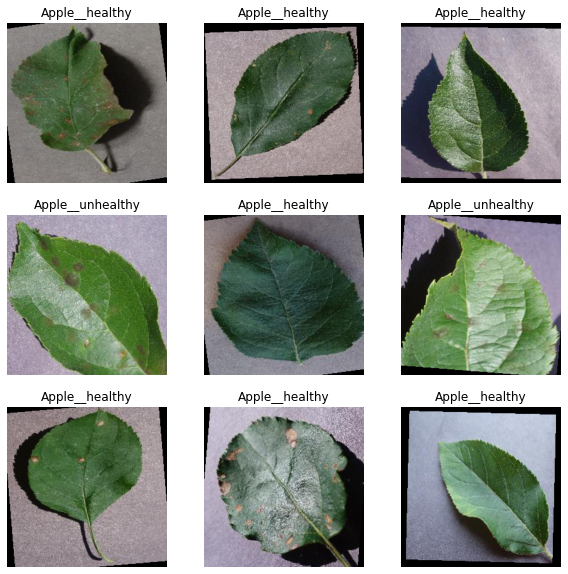

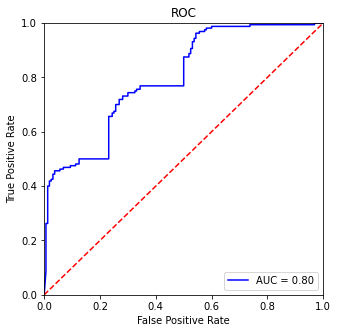

In [20]:
predict_and_print_roc(model2);


### 3. Create and compile model 3
This model has like the previous model three convolution layers. It starts with a small number of neurons and gradually increases its neuron amount. In between every convolution layer, a max pooling layer manipulates the values. Additionally, 20% of random values are dropped at the end of the hidden layers. The result from the hidden layers is then flattened with three dense layers that again gradually become smaller.

In [21]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),
                           padding='same', activation='relu', use_bias=False),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),
                       padding='same', activation='relu', use_bias=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu', use_bias=False),
    tf.keras.layers.Dense(8, activation='relu', use_bias=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=METRICS)

### 4. Display model structure 3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      864       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18432     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       73728     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)      

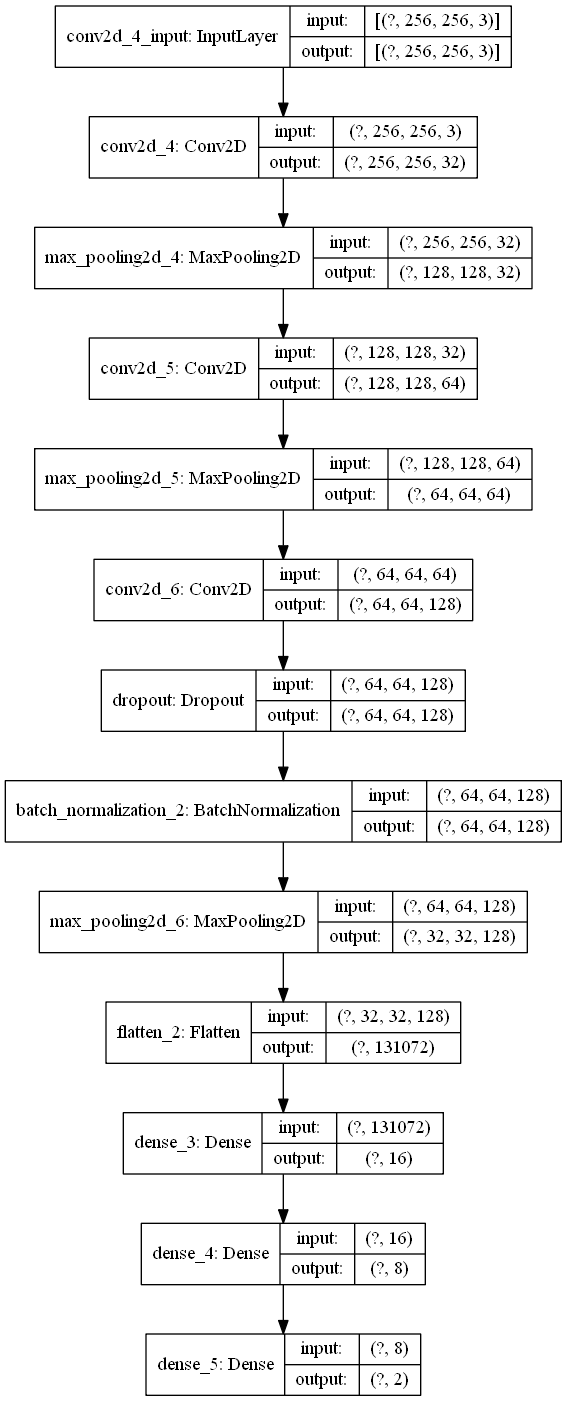

In [23]:
model3.summary()
tf.keras.utils.plot_model(model3, show_shapes=True)

### 5. Training model 3

In [24]:
history3 = train_model(model3, "Model_3")

Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 0.8121 - tp: 1501.0000 - fp: 671.0000 - tn: 1501.0000 - fn: 671.0000 - accuracy: 0.6911 - precision: 0.6911 - auc: 0.7374 - mae: 0.3396 - mse: 0.2369
Epoch 00001: val_accuracy improved from -inf to 0.62698, saving model to ./models\Model_3.hdf5
46/46 [==============================] - 17s 362ms/step - loss: 0.8121 - tp: 1501.0000 - fp: 671.0000 - tn: 1501.0000 - fn: 671.0000 - accuracy: 0.6911 - precision: 0.6911 - auc: 0.7374 - mae: 0.3396 - mse: 0.2369 - val_loss: 0.6015 - val_tp: 79.0000 - val_fp: 47.0000 - val_tn: 79.0000 - val_fn: 47.0000 - val_accuracy: 0.6270 - val_precision: 0.6270 - val_auc: 0.7532 - val_mae: 0.4324 - val_mse: 0.2077
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.3401 - tp: 1256.0000 - fp: 202.0000 - tn: 1256.0000 - fn: 202.0000 - accuracy: 0.8615 - precision: 0.8615 - auc: 0.9323 - mae: 0.1857 - mse: 0.1016
Epoch 00002: val_accuracy improved from 0.62698 to 0.91270, sav

Epoch 13/25
46/46 [==============================] - ETA: 0s - loss: 0.1739 - tp: 1362.0000 - fp: 96.0000 - tn: 1362.0000 - fn: 96.0000 - accuracy: 0.9342 - precision: 0.9342 - auc: 0.9810 - mae: 0.0967 - mse: 0.0499
Epoch 00013: val_accuracy did not improve from 0.96825
46/46 [==============================] - 15s 337ms/step - loss: 0.1739 - tp: 1362.0000 - fp: 96.0000 - tn: 1362.0000 - fn: 96.0000 - accuracy: 0.9342 - precision: 0.9342 - auc: 0.9810 - mae: 0.0967 - mse: 0.0499 - val_loss: 0.2048 - val_tp: 118.0000 - val_fp: 8.0000 - val_tn: 118.0000 - val_fn: 8.0000 - val_accuracy: 0.9365 - val_precision: 0.9365 - val_auc: 0.9746 - val_mae: 0.1165 - val_mse: 0.0510
Epoch 14/25
46/46 [==============================] - ETA: 0s - loss: 0.1902 - tp: 1356.0000 - fp: 102.0000 - tn: 1356.0000 - fn: 102.0000 - accuracy: 0.9300 - precision: 0.9300 - auc: 0.9773 - mae: 0.1014 - mse: 0.0542
Epoch 00014: val_accuracy did not improve from 0.96825
46/46 [==============================] - 15s 336ms

46/46 [==============================] - ETA: 0s - loss: 0.1621 - tp: 1362.0000 - fp: 96.0000 - tn: 1362.0000 - fn: 96.0000 - accuracy: 0.9342 - precision: 0.9342 - auc: 0.9845 - mae: 0.0839 - mse: 0.0479
Epoch 00025: val_accuracy improved from 0.96825 to 0.97619, saving model to ./models\Model_3.hdf5
46/46 [==============================] - 15s 335ms/step - loss: 0.1621 - tp: 1362.0000 - fp: 96.0000 - tn: 1362.0000 - fn: 96.0000 - accuracy: 0.9342 - precision: 0.9342 - auc: 0.9845 - mae: 0.0839 - mse: 0.0479 - val_loss: 0.1187 - val_tp: 123.0000 - val_fp: 3.0000 - val_tn: 123.0000 - val_fn: 3.0000 - val_accuracy: 0.9762 - val_precision: 0.9762 - val_auc: 0.9870 - val_mae: 0.0370 - val_mse: 0.0231


### 6. Display History 3

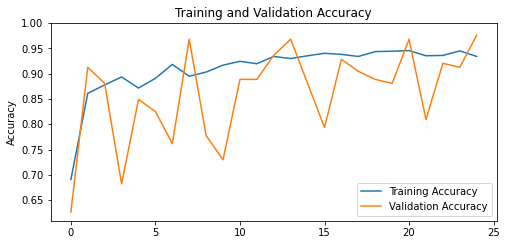

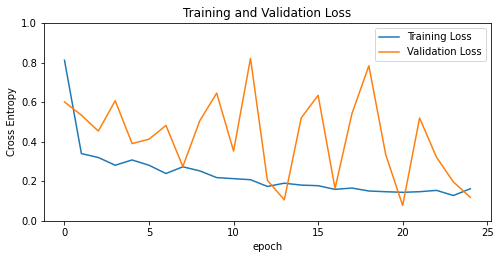

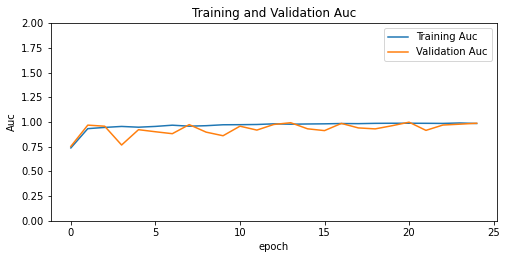

In [25]:
print_history(history3)

### 7. Evaluate the model 3

In [26]:
print_model_evaluation(model3);

714/714 [==============================] - 3s 4ms/step - loss: 0.4579 - tp: 666.0000 - fp: 48.0000 - tn: 666.0000 - fn: 48.0000 - accuracy: 0.9328 - precision: 0.9328 - auc: 0.9721 - mae: 0.0834 - mse: 0.0561
loss : 0.458
tp : 666.0
fp : 48.0
tn : 666.0
fn : 48.0
accuracy : 0.933
precision : 0.933
auc : 0.972
mae : 0.083
mse : 0.056


### 8. Predict with model 3

Label Predictions:
 [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Real Labels:
 [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]

Con

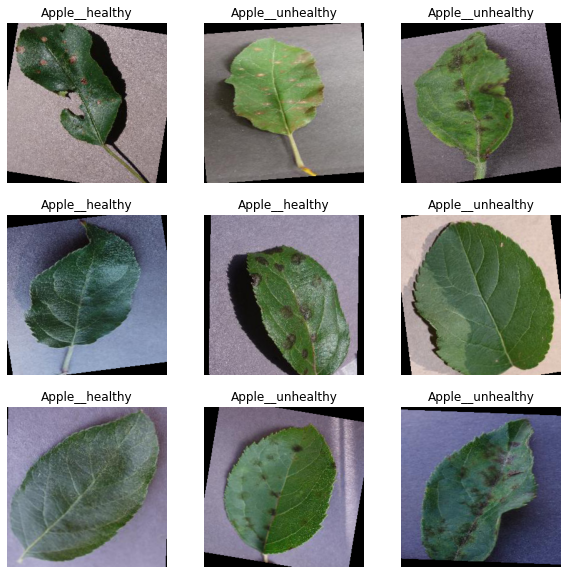

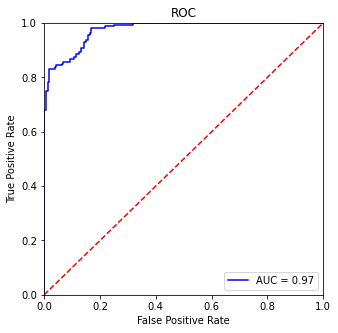

In [27]:
predict_and_print_roc(model3);

### 9. Save test model

In [32]:
model3.save(MODEL_NAME)

### 10. Load test model

In [33]:
loaded_model = tf.keras.models.load_model(MODEL_NAME)

### 11. Test loaded model on image:

Expected result: [1, 0] 

Result:  [[1. 0.]] 



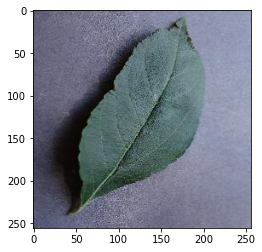

In [34]:
healthyTestImagePath = "./plant_images/test/Apple__healthy/2d7f4c07-f4f4-4589-aa82-49e05e5b253b___RS_HL 8056.jpg"

healthyTestImage = image.load_img(healthyTestImagePath)
plt.imshow(healthyTestImage)
healthyTestImage = (np.expand_dims(healthyTestImage,0))
predictions = loaded_model.predict(healthyTestImage)

print('Expected result: [1, 0] \n')
print('Result: ', predictions, '\n')

Expected result: [0, 1] 

Result:  [[0. 1.]] 



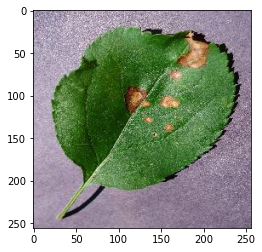

In [35]:
unhealthyTestImagePath = "./plant_images/test/Apple__unhealthy/0ebea6f4-08e4-4380-86f8-34d854697e32___JR_FrgE.S 2877.jpg"
unhealthyTestImage = image.load_img(unhealthyTestImagePath)
plt.imshow(unhealthyTestImage)
unhealthyTestImage = (np.expand_dims(unhealthyTestImage,0))
predictions = loaded_model.predict(unhealthyTestImage)

print('Expected result: [0, 1] \n')
print('Result: ', predictions, '\n')




## Summary
* All the models were trained with 25 epochs. The reason for this is that after this amount the results were sufficient for comparison and overfitting could be avoided(tested with 50 epochs before). Model training is also very expensive which makes it harder to refine the models.
* The batch normalization in each model was necessary to create stable runs. Without it, the training of the model converged to a loss of 0.5 at some runs. Without the batch normalization model 2 and 3 had better results, which however were quite unstable.
* Models with more than three convolution layers did not improve the models at all and were therefore not added to the final test models. 

### Model 1: 
This is a very simple model that worked the very well. Showing that a small amount of layers can already create a very good model.

### Model 2: 
Has more hidden and dense layers than model 1. Increasing the number of neurons in each layer, however, didn't seem to work as well as expected. Surprisingly, the result is even worse than model one, which uses a lot fewer layers. Based on the parameter it even has the same amount than model 1. 

### Model 3: 
This model seems to perform just as good as model 1, based on the false positive and false negative validation. Decreasing the size of the image and the neurons and leaving the amount of layers around 2-3 seemed however to work best for this image recognition.

## Additional Experiments
Out of couriosity we've also recreated the same model in ML.NET integrated in an .NET Core Web Application. See additional document.
